# Tổ chức data

## Thư viện cần thiết

In [1]:
import os
import shutil
import numpy as np
from PIL import Image
from tqdm import tqdm

## Xử lý data

In [2]:
INPUT_ROOT = "/kaggle/input/dataset-40000-new/dataset_40000_new"
OUTPUT_DIR = "/kaggle/working/dataset_diff_palm"
TARGET_FILENAME = "samples_400x128x128x3.npz"

# Số lượng ảnh của MỖI người
IDS_PER_BATCH = 20

def process_nested_dataset():
    if not os.path.exists(INPUT_ROOT):
        print(f"Không tìm thấy đường dẫn {INPUT_ROOT}")
        return

    # Reset thư mục đầu ra
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)
    
    os.makedirs(OUTPUT_DIR)

    # Lấy danh sách thư mục con và sắp xếp theo số
    subfolders = [f for f in os.listdir(INPUT_ROOT) if f.startswith("data_") and os.path.isdir(os.path.join(INPUT_ROOT, f))]
    
    try:
        subfolders.sort(key=lambda x: int(x.split('_')[1]))
    except:
        print("Tên thư mục không chuẩn định dạng 'data_Start_End'.")


    total_images_count = 0

    for folder_name in tqdm(subfolders, desc="Processing Folders"):
        folder_path = os.path.join(INPUT_ROOT, folder_name)

        # 1. Lấy ID bắt đầu của batch này (VD: data_20_39 -> start=20)
        try:
            parts = folder_name.split('_') 
            start_node_id = int(parts[1])
        except:
            continue

        npz_path = os.path.join(folder_path, TARGET_FILENAME)
        
        if not os.path.exists(npz_path):
            continue

        try:
            data = np.load(npz_path)
            # Lấy key đầu tiên hoặc arr_0
            key = list(data.keys())[0]
            images = data[key] 
        except Exception as e:
            print(f"Lỗi đọc file trong {folder_name}: {e}")
            continue

        # 2. DUYỆT QUA TỪNG ẢNH VÀ TÍNH ID
        for i in range(images.shape[0]):
            offset = i // IDS_PER_BATCH   
            
            global_id = start_node_id + offset

            # Xử lý ảnh
            img_array = images[i]
            if img_array.dtype != np.uint8:
                if img_array.max() <= 1.0: 
                    img_array = (img_array * 255).astype(np.uint8)
                else:
                    img_array = img_array.astype(np.uint8)

            # Tạo thư mục ID đích
            target_id_folder = os.path.join(OUTPUT_DIR, f"id_{global_id:04d}")
            os.makedirs(target_id_folder, exist_ok=True)

            # Lưu ảnh
            save_filename = f"{folder_name}_{i}.png"
            Image.fromarray(img_array).save(os.path.join(target_id_folder, save_filename))
            
            total_images_count += 1

    print(f"HOÀN TẤT")

process_nested_dataset()

Processing Folders: 100%|██████████| 100/100 [05:06<00:00,  3.07s/it]

HOÀN TẤT


## Xem thử vài mẫu

In [3]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

In [4]:
def show_random_samples(DATA_DIR, NUM_IDS_TO_SHOW = 3, SAMPLES_PER_ID = 5):
    if not os.path.exists(DATA_DIR):
        print(f"Không tìm thấy thư mục: {DATA_DIR}")
        return

    # Lấy danh sách tất cả các folder ID
    all_ids = sorted([d for d in os.listdir(DATA_DIR) if d.startswith("id_")])
    
    if not all_ids:
        print("Thư mục rỗng!")
        return


    selected_ids = random.sample(all_ids, min(len(all_ids), NUM_IDS_TO_SHOW)) 
    
    print(f"Đang hiển thị mẫu cho các ID: {selected_ids}")

    # Thiết lập khung hình
    fig, axes = plt.subplots(NUM_IDS_TO_SHOW, SAMPLES_PER_ID, figsize=(15, 3 * NUM_IDS_TO_SHOW))
    
    # Xử lý trường hợp chỉ hiển thị 1 dòng để tránh lỗi vòng lặp
    if NUM_IDS_TO_SHOW == 1: 
        axes = [axes]

    for row_idx, id_name in enumerate(selected_ids):
        id_path = os.path.join(DATA_DIR, id_name)
        
        # Lấy danh sách ảnh trong folder ID đó
        images = [f for f in os.listdir(id_path) if f.endswith(('.png', '.jpg'))]
        
        if not images:
            continue
            
        # Chọn ngẫu nhiên các ảnh con
        selected_imgs = random.sample(images, min(len(images), SAMPLES_PER_ID))
        
        for col_idx, img_name in enumerate(selected_imgs):
            img_path = os.path.join(id_path, img_name)
            
            try:
                img = Image.open(img_path)
                
                ax = axes[row_idx][col_idx] if NUM_IDS_TO_SHOW > 1 else axes[col_idx]
                
                ax.imshow(img, cmap='gray')
                ax.axis('off') # Tắt trục tọa độ
                
                if col_idx == 0:
                    ax.set_title(f"{id_name}\n({len(images)} ảnh)", fontsize=12, fontweight='bold', loc='left')
                    
            except Exception as e:
                print(f"Lỗi không mở được ảnh {img_path}: {e}")

    plt.tight_layout()
    plt.show()

Đang hiển thị mẫu cho các ID: ['id_1518', 'id_0221', 'id_1779']


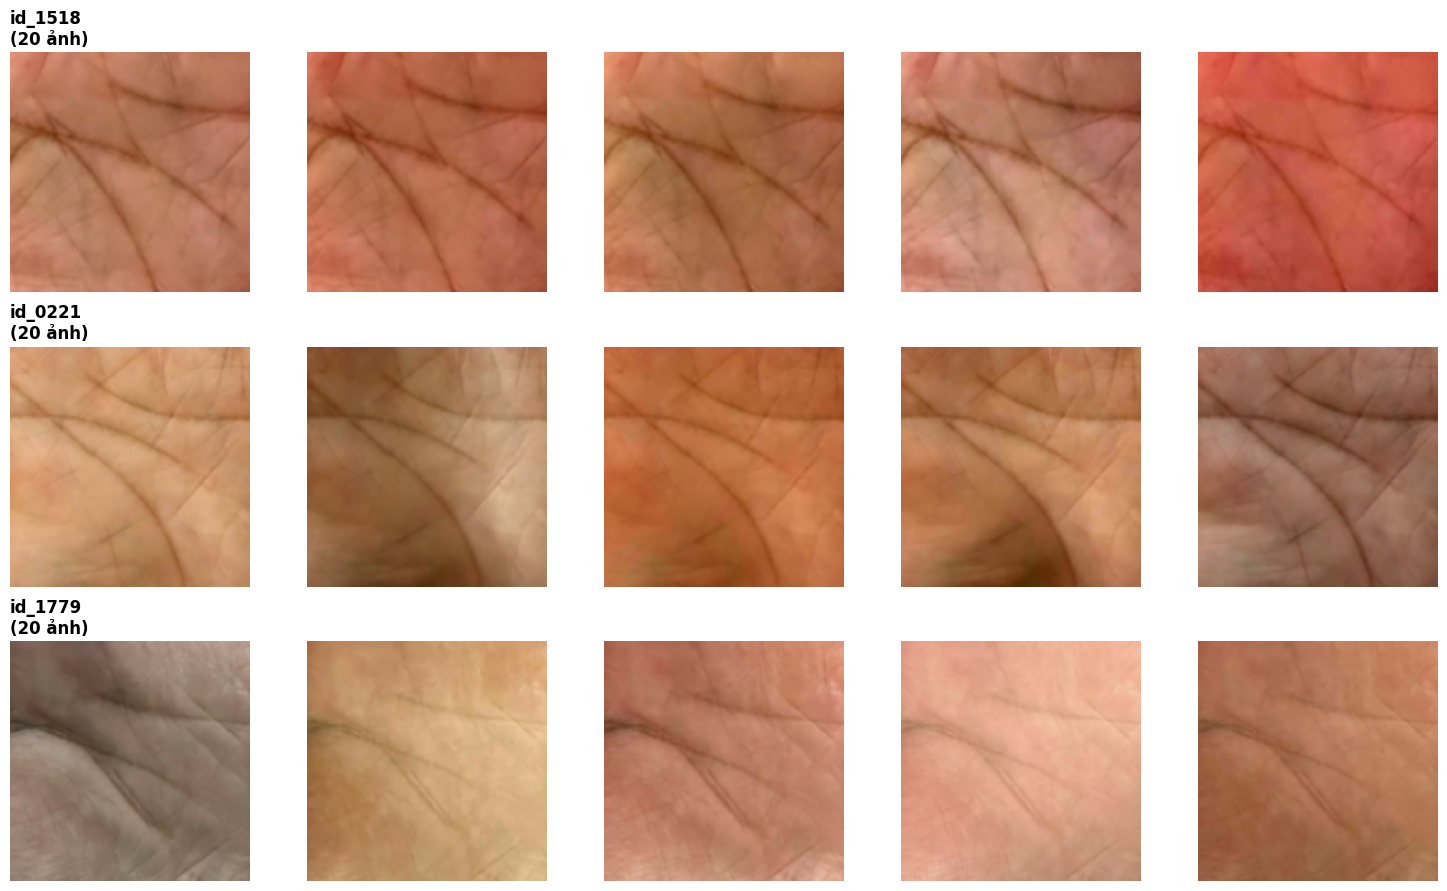

In [5]:
show_random_samples("/kaggle/working/dataset_diff_palm")

# Cài đặt mô hình

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import os
import math
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

## Backbone Modified ResNet-18

In [7]:
class ModifiedResNet18(nn.Module):
    def __init__(self, embedding_size=512, dropout_prob=0):
        super(ModifiedResNet18, self).__init__()
        self.model = models.resnet18(weights="DEFAULT") 
        
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        
        # Embedding Layer
        self.model.fc = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout_prob),
            nn.Linear(512, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.fc(x)
        return x

## ArcFace Head

In [8]:
class ArcFaceHead(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5):
        super(ArcFaceHead, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        
        # Khởi tạo các hằng số toán học
        self.update_margin(m)

    # Hàm hỗ trợ cập nhật margin động (cho Warmup)
    def update_margin(self, m):
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, embedding, label):
        cosine = F.linear(F.normalize(embedding), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        one_hot = torch.zeros(cosine.size(), device=embedding.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

# Huấn luyện mô hình

In [9]:
CONFIG = {
    "data_dir": "/kaggle/working/dataset_diff_palm", 
    "image_size": 112,
    "batch_size": 256,    
    "lr": 0.1,            
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "epochs": 20,
    "milestones": [7,15],
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    
    # ArcFace params
    "s": 32.0,      
    "m": 0.2,       
}

In [10]:
# Transform cho Train
train_transform = transforms.Compose([
    transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
    transforms.RandAugment(num_ops=4, magnitude=4), 
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load toàn bộ dataset
full_dataset = datasets.ImageFolder(root=CONFIG["data_dir"], transform=train_transform)


train_loader = DataLoader(full_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=4, pin_memory=True)


num_classes = len(full_dataset.classes)
print(f"Data Loaded: {len(full_dataset)} images | {num_classes} IDs")

# --- PHẦN 3: SETUP MODEL ---
backbone = ModifiedResNet18(embedding_size=512).to(CONFIG["device"])
head = ArcFaceHead(in_features=512, out_features=num_classes, s=CONFIG["s"], m=CONFIG["m"]).to(CONFIG["device"])

optimizer = optim.SGD(
    list(backbone.parameters()) + list(head.parameters()),
    lr=CONFIG["lr"],
    momentum=CONFIG["momentum"],
    weight_decay=CONFIG["weight_decay"]
)

scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=CONFIG["milestones"],
    gamma=0.1
)

criterion = nn.CrossEntropyLoss()

print("Start Training (Verification Mode - ArcFace)")
for epoch in range(CONFIG["epochs"]):
    if epoch < 3:
        curr_m = 0.0
    elif epoch < 6:
        curr_m = 0.1
    else:
        curr_m = CONFIG["m"]

    head.update_margin(curr_m)
    # ----------------------
    # 1. TRAIN PHASE
    # ----------------------
    backbone.train()
    head.train()
    
    running_loss = 0.0
    
    
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{CONFIG['epochs']} [Train]")
    for images, labels in pbar:
        images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
        
        optimizer.zero_grad()
        embeddings = backbone(images)
        embeddings = F.normalize(embeddings) 

        logits = head(embeddings, labels)

        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
    
    scheduler.step()
    
    avg_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Avg Training Loss: {avg_loss:.4f}")

    if (epoch + 1) % 5 == 0 or (epoch + 1) == CONFIG["epochs"]:
        save_path = f"arcface_resnet18_ep{epoch+1}.pth"
        torch.save(backbone.state_dict(), save_path)
        print(f"Saved checkpoint: {save_path}")
    
    print("-" * 50)


Data Loaded: 40000 images | 2000 IDs
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


Start Training (Verification Mode - ArcFace)


Ep 1/20 [Train]: 100%|██████████| 157/157 [08:40<00:00,  3.31s/it, Loss=8.5215]


[Epoch 1] Avg Training Loss: 8.8757
--------------------------------------------------


Ep 2/20 [Train]: 100%|██████████| 157/157 [08:51<00:00,  3.39s/it, Loss=4.7915]


[Epoch 2] Avg Training Loss: 7.4240
--------------------------------------------------


Ep 3/20 [Train]: 100%|██████████| 157/157 [08:54<00:00,  3.40s/it, Loss=0.3478]


[Epoch 3] Avg Training Loss: 1.7850
--------------------------------------------------


Ep 4/20 [Train]: 100%|██████████| 157/157 [08:54<00:00,  3.40s/it, Loss=0.2161]


[Epoch 4] Avg Training Loss: 0.5875
--------------------------------------------------


Ep 5/20 [Train]: 100%|██████████| 157/157 [08:54<00:00,  3.40s/it, Loss=0.1332]


[Epoch 5] Avg Training Loss: 0.0831
Saved checkpoint: arcface_resnet18_ep5.pth
--------------------------------------------------


Ep 6/20 [Train]: 100%|██████████| 157/157 [08:53<00:00,  3.40s/it, Loss=0.0243]


[Epoch 6] Avg Training Loss: 0.0399
--------------------------------------------------


Ep 7/20 [Train]: 100%|██████████| 157/157 [08:54<00:00,  3.40s/it, Loss=0.2315]


[Epoch 7] Avg Training Loss: 0.1707
--------------------------------------------------


Ep 8/20 [Train]: 100%|██████████| 157/157 [08:53<00:00,  3.40s/it, Loss=0.0538]


[Epoch 8] Avg Training Loss: 0.0373
--------------------------------------------------


Ep 9/20 [Train]: 100%|██████████| 157/157 [08:53<00:00,  3.40s/it, Loss=0.0210]


[Epoch 9] Avg Training Loss: 0.0243
--------------------------------------------------


Ep 10/20 [Train]: 100%|██████████| 157/157 [08:54<00:00,  3.40s/it, Loss=0.0172]


[Epoch 10] Avg Training Loss: 0.0226
Saved checkpoint: arcface_resnet18_ep10.pth
--------------------------------------------------


Ep 11/20 [Train]: 100%|██████████| 157/157 [08:54<00:00,  3.40s/it, Loss=0.0318]


[Epoch 11] Avg Training Loss: 0.0181
--------------------------------------------------


Ep 12/20 [Train]: 100%|██████████| 157/157 [08:54<00:00,  3.41s/it, Loss=0.0645]


[Epoch 12] Avg Training Loss: 0.0180
--------------------------------------------------


Ep 13/20 [Train]: 100%|██████████| 157/157 [08:54<00:00,  3.40s/it, Loss=0.0258]


[Epoch 13] Avg Training Loss: 0.0165
--------------------------------------------------


Ep 14/20 [Train]: 100%|██████████| 157/157 [08:54<00:00,  3.40s/it, Loss=0.0128]


[Epoch 14] Avg Training Loss: 0.0152
--------------------------------------------------


Ep 15/20 [Train]: 100%|██████████| 157/157 [08:54<00:00,  3.40s/it, Loss=0.0087]


[Epoch 15] Avg Training Loss: 0.0139
Saved checkpoint: arcface_resnet18_ep15.pth
--------------------------------------------------


Ep 16/20 [Train]: 100%|██████████| 157/157 [08:53<00:00,  3.40s/it, Loss=0.0274]


[Epoch 16] Avg Training Loss: 0.0142
--------------------------------------------------


Ep 17/20 [Train]: 100%|██████████| 157/157 [08:53<00:00,  3.40s/it, Loss=0.0219]


[Epoch 17] Avg Training Loss: 0.0135
--------------------------------------------------


Ep 18/20 [Train]: 100%|██████████| 157/157 [08:54<00:00,  3.40s/it, Loss=0.0206]


[Epoch 18] Avg Training Loss: 0.0123
--------------------------------------------------


Ep 19/20 [Train]: 100%|██████████| 157/157 [08:53<00:00,  3.40s/it, Loss=0.0180]


[Epoch 19] Avg Training Loss: 0.0129
--------------------------------------------------


Ep 20/20 [Train]: 100%|██████████| 157/157 [08:53<00:00,  3.40s/it, Loss=0.0165]

[Epoch 20] Avg Training Loss: 0.0126
Saved checkpoint: arcface_resnet18_ep20.pth
--------------------------------------------------


# Inference trên Tongji

## Xử lý dữ liệu

In [11]:
INPUT_DIR = "/kaggle/input/tongji-train/DATASETS/palm" 

OUTPUT_DIR = "/kaggle/working/tongji_formatted"

def process_tongji_dataset(input_path, output_path, IMGS_PER_ID = 10):
    # 1. Kiểm tra đầu vào
    if not os.path.exists(input_path):
        print(f"Không tìm thấy thư mục: {input_path}")
        return

    # 2. Reset thư mục đầu ra
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path)

    # 3. Lấy danh sách file và SẮP XẾP SỐ HỌC
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    all_files = [f for f in os.listdir(INPUT_DIR) if f.lower().endswith(valid_exts)]
    
    try:
        all_files.sort(key=lambda x: int(os.path.splitext(x)[0]))
    except ValueError:
        all_files.sort()

    # 4. Duyệt và Copy
    count = 0
    for i, filename in enumerate(tqdm(all_files, desc="Đang xử lý")):
        current_id = i // IMGS_PER_ID
        
        # Tạo thư mục ID
        target_folder = os.path.join(OUTPUT_DIR, f"id_{current_id:04d}")
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
            
        # Copy file
        src_path = os.path.join(INPUT_DIR, filename)
        dst_path = os.path.join(target_folder, filename)
        
        shutil.copy(src_path, dst_path)
        count += 1

    print("\n" + "="*40)
    print("HOÀN TẤT XỬ LÝ TONGJI")
    print("="*40)

process_tongji_dataset(INPUT_DIR, OUTPUT_DIR)

Đang xử lý: 100%|██████████| 12000/12000 [01:23<00:00, 143.72it/s]


HOÀN TẤT XỬ LÝ TONGJI


## CONFIG

In [12]:
import numpy as np
import os
import shutil
from PIL import Image
from tqdm import tqdm
from glob import glob

In [20]:
DATA_DIR = "/kaggle/working/tongji_formatted"  # Đường dẫn Tongji
MODEL_PATH = "/kaggle/working/arcface_resnet18_ep20.pth"       # Đường dẫn model vừa train xong
BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
def get_embeddings(model, loader):
    embeddings = []
    labels = []
    
    print("🚀 Đang trích xuất đặc trưng (Embeddings)...")
    with torch.no_grad():
        for imgs, lbls in tqdm(loader):
            imgs = imgs.to(DEVICE)
            
            # Lấy vector đặc trưng
            emb = model(imgs)
            
            # Chuẩn hóa vector về đơn vị (Norm=1) để tính Cosine
            emb = F.normalize(emb, p=2, dim=1)
            
            embeddings.append(emb.cpu())
            labels.append(lbls)
            
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

def evaluate_tar_far(embeddings, labels, far_target=1e-6):
    if torch.cuda.is_available():
        embeddings = embeddings.cuda()
        labels = labels.cuda()

    # Kết quả là ma trận N x N (12000 x 12000)
    sim_matrix = torch.mm(embeddings, embeddings.t())
    
    # Tạo ma trận nhãn đúng (Ground Truth): 1 nếu cùng ID, 0 nếu khác ID
    label_matrix = labels.unsqueeze(1) == labels.unsqueeze(0)
    
    # Loại bỏ đường chéo chính (Ảnh tự so sánh với chính nó luôn = 1)
    # dùng tam giác trên (Upper Triangle) để tránh tính lặp lại (A vs B và B vs A)
    # k=1 nghĩa là bỏ đường chéo, chỉ lấy phần trên
    triu_indices = torch.triu_indices(row=len(labels), col=len(labels), offset=1)
    
    # Lấy các cặp index
    rows = triu_indices[0]
    cols = triu_indices[1]
    
    # Lấy điểm số (scores) và nhãn (truth) tương ứng
    scores = sim_matrix[rows, cols]
    truth = label_matrix[rows, cols]
    
    # Tách Positives và Negatives
    pos_scores = scores[truth == True].cpu().numpy()
    neg_scores = scores[truth == False].cpu().numpy()
    
    print(f"📊 Thống kê cặp:")
    print(f"   - Tổng số cặp so sánh: {len(scores):,}")
    print(f"   - Cặp chính chủ (Positive): {len(pos_scores):,} (Kỳ vọng điểm cao)")
    print(f"   - Cặp giả mạo (Negative):   {len(neg_scores):,} (Kỳ vọng điểm thấp)")

    # --- TÍNH TOÁN NGƯỠNG ---
    # Sắp xếp điểm giả mạo từ CAO xuống THẤP
    neg_scores_sorted = np.sort(neg_scores)[::-1]
    
    # Tìm vị trí cắt tại FAR mục tiêu
    # FAR = 1e-6 nghĩa là trong 1 triệu kẻ giả mạo, chỉ lọt 1 người
    num_neg = len(neg_scores)
    cut_index = int(num_neg * far_target)
    
    # Đảm bảo index hợp lệ
    cut_index = max(0, min(cut_index, num_neg - 1))
    
    # Ngưỡng (Threshold)
    threshold = neg_scores_sorted[cut_index]
    
    # Tính TAR: Tỷ lệ người thật có điểm CAO HƠN ngưỡng
    true_accepts = np.sum(pos_scores > threshold)
    tar = true_accepts / len(pos_scores)
    
    return tar, threshold, pos_scores, neg_scores

🚀 Đang trích xuất đặc trưng (Embeddings)...


100%|██████████| 94/94 [00:36<00:00,  2.61it/s]


Đã lấy xong: torch.Size([12000, 512]) vectors.

🛡️ KẾT QUẢ BẢO MẬT (ARCFACE - COSINE SIMILARITY)
FAR Target      | Threshold (Cosine)   | TAR (Nhận đúng)
--------------------------------------------------
📊 Thống kê cặp:
   - Tổng số cặp so sánh: 71,994,000
   - Cặp chính chủ (Positive): 54,000 (Kỳ vọng điểm cao)
   - Cặp giả mạo (Negative):   71,940,000 (Kỳ vọng điểm thấp)
0.001           | 0.8071               | 93.4463%


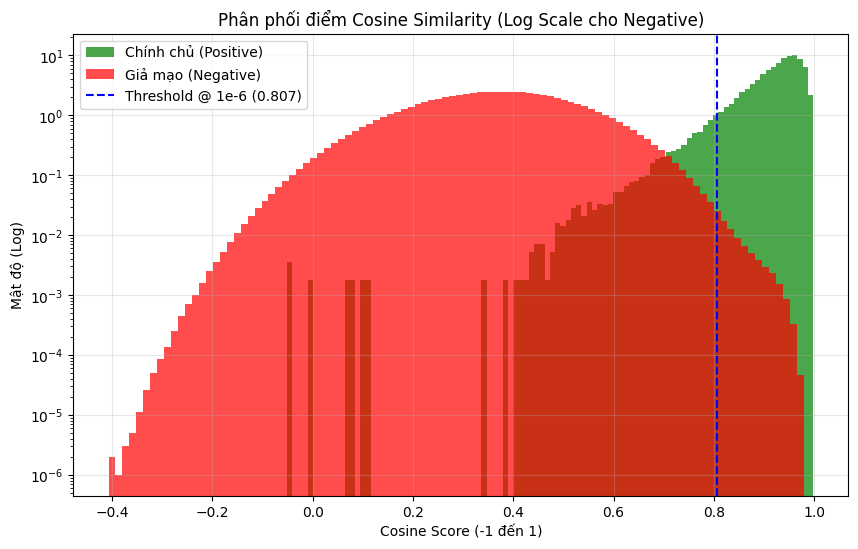

In [21]:
test_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = datasets.ImageFolder(DATA_DIR, transform=test_transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Load Model (Giả sử class ModifiedResNet18 đã được định nghĩa)
model = ModifiedResNet18(embedding_size=512).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

embeddings, labels = get_embeddings(model, dataloader)

print(f"Đã lấy xong: {embeddings.shape} vectors.")

# --- 4. CHẠY ĐÁNH GIÁ ---
# Các mốc FAR quan trọng
far_levels = [1e-3] 

print("\n" + "="*50)
print("🛡️ KẾT QUẢ BẢO MẬT (ARCFACE - COSINE SIMILARITY)")
print("="*50)
print(f"{'FAR Target':<15} | {'Threshold (Cosine)':<20} | {'TAR (Nhận đúng)':<15}")
print("-" * 50)

final_pos = []
final_neg = []

for far in far_levels:
    tar, thresh, pos, neg = evaluate_tar_far(embeddings, labels, far_target=far)
    print(f"{far:<15} | {thresh:<20.4f} | {tar*100:.4f}%")
    final_pos = pos
    final_neg = neg # Lưu lại để vẽ biểu đồ

# --- 5. VẼ BIỂU ĐỒ PHÂN PHỐI ---
plt.figure(figsize=(10, 6))
plt.hist(final_pos, bins=100, alpha=0.7, color='green', label='Chính chủ (Positive)', density=True)
plt.hist(final_neg, bins=100, alpha=0.7, color='red', label='Giả mạo (Negative)', density=True, log=True) # Log scale để nhìn thấy đuôi FAR thấp
plt.axvline(thresh, color='blue', linestyle='--', label=f'Threshold @ 1e-6 ({thresh:.3f})')
plt.title('Phân phối điểm Cosine Similarity (Log Scale cho Negative)')
plt.xlabel('Cosine Score (-1 đến 1)')
plt.ylabel('Mật độ (Log)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
